In [24]:
import copy
import math
import random
import time
from collections import OrderedDict, defaultdict
from typing import Union, List

import numpy as np
import torch
from matplotlib import pyplot as plt
from torch import nn
from torch.optim import *
from torch import optim
from torch.optim.lr_scheduler import *
from torch.utils.data import DataLoader
from torchprofile import profile_macs
from torchvision.datasets import *
from torchvision.transforms import *
from tqdm.auto import tqdm
import torchvision.transforms as transforms
import torchvision

from torchprofile import profile_macs

assert torch.cuda.is_available(), \
"The current runtime does not have CUDA support." \
"Please go to menu bar (Runtime - Change runtime type) and select GPU"

In [25]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

In [26]:


image_size = 32
batch_size = 128
transforms = {
    "train": transforms.Compose([
        RandomCrop(image_size, padding=4),
        RandomHorizontalFlip(),
        ToTensor(),
    ]),
    "test": ToTensor(),
}
dataset = {}
for split in ["train", "test"]:
    dataset[split] =  MNIST('./files/', train=(split == "train"), download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))
dataloader = {}
for split in ['train', 'test']:
    dataloader[split] = DataLoader(
    dataset[split],
    batch_size=batch_size,
    shuffle=(split == 'train'),
    num_workers=8,
    pin_memory=True,
    )

In [5]:
data = dataloader['train']
images, label = next(iter(data))

images.shape, label

(torch.Size([128, 1, 28, 28]),
 tensor([6, 8, 8, 7, 8, 0, 0, 5, 6, 0, 0, 3, 5, 8, 1, 6, 2, 4, 1, 4, 9, 4, 3, 4,
         1, 4, 8, 7, 6, 3, 1, 8, 4, 4, 6, 2, 4, 2, 9, 5, 7, 8, 0, 7, 5, 5, 9, 3,
         6, 6, 4, 6, 7, 8, 3, 6, 2, 2, 7, 7, 2, 4, 4, 9, 9, 5, 2, 2, 9, 0, 9, 4,
         6, 5, 8, 5, 7, 1, 4, 2, 1, 8, 8, 6, 9, 7, 8, 0, 0, 8, 8, 6, 5, 0, 6, 9,
         7, 4, 1, 8, 1, 4, 0, 3, 5, 4, 6, 8, 1, 8, 7, 5, 5, 6, 0, 6, 5, 4, 9, 2,
         6, 0, 3, 1, 5, 8, 4, 0]))

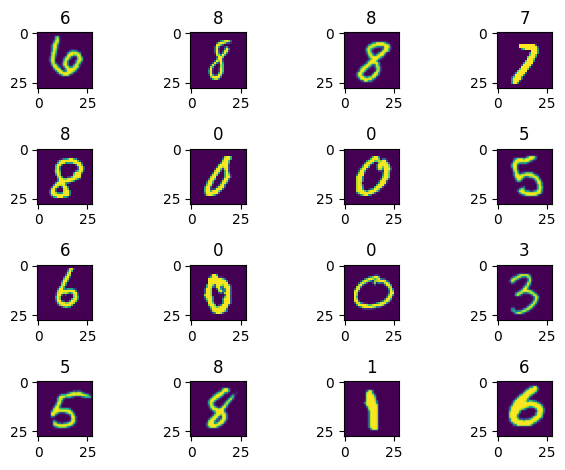

In [17]:
n =4
ind = 0
fig, axs = plt.subplots(n, n)
for row_i in range(n):
    for col_j in range(n):
        axs[row_i, col_j].imshow(images[ind,0,:])
        axs[row_i, col_j].set_title(label[ind].item())
        ind+=1
fig.tight_layout()
plt.show()


In [55]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 2, 3)
        self.bn1 = nn.BatchNorm2d(2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(2, 4, 3)
        self.bn2 = nn.BatchNorm2d(4)
        self.fc1 = nn.Linear(4*5*5, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.pool(self.bn1(F.relu(self.conv1(x))))
        x = self.pool(self.bn2(F.relu(self.conv2(x))))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    



In [60]:

def train(model):
    epoch = 20
    torch.cuda.empty_cache()

    model = model.to('cuda')

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)


    val_acc = []
    val_acc_glo = 0
    for epoch in range(epoch):  # loop over the dataset multiple times
    
        running_loss = 0.0
        for i, data in enumerate(dataloader['train'], 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to("cuda"), labels.to("cuda")

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
        print(f'[{epoch + 1}] loss: {running_loss / 2000:.3f}')
        running_loss = 0.0



        val_acc = validate(model, dataloader['train'])
        if(val_acc_glo < val_acc):
             torch.save(model.state_dict(), 'resnet.pth')


    


In [64]:
def validate(net, testloader):
    net.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in testloader:
            images, labels = images.to("cuda"), labels.to("cuda")
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        acc = 100 * correct / total

        print('Test Accuracy: {} %'.format(acc))
        return acc

In [62]:
def get_model_macs(model, inputs) -> int:
    return profile_macs(model, inputs)


def get_sparsity(tensor: torch.Tensor) -> float:
    """
    calculate the sparsity of the given tensor
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    """
    return 1 - float(tensor.count_nonzero()) / tensor.numel()


def get_model_sparsity(model: nn.Module) -> float:
    """
    calculate the sparsity of the given model
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    """
    num_nonzeros, num_elements = 0, 0
    for param in model.parameters():
        num_nonzeros += param.count_nonzero()
        num_elements += param.numel()
    return 1 - float(num_nonzeros) / num_elements

def get_num_parameters(model: nn.Module, count_nonzero_only=False) -> int:
    """
    calculate the total number of parameters of model
    :param count_nonzero_only: only count nonzero weights
    """
    num_counted_elements = 0
    for param in model.parameters():
        if count_nonzero_only:
            num_counted_elements += param.count_nonzero()
        else:
            num_counted_elements += param.numel()
    return num_counted_elements


def get_model_size(model: nn.Module, data_width=32, count_nonzero_only=False) -> int:
    """
    calculate the model size in bits
    :param data_width: #bits per element
    :param count_nonzero_only: only count nonzero weights
    """
    return get_num_parameters(model, count_nonzero_only) * data_width

Byte = 8
KiB = 1024 * Byte
MiB = 1024 * KiB
GiB = 1024 * MiB

In [63]:
net = Net()
train(net)

[1] loss: 0.399
Test Accuracy: 77.69833333333334 %
[2] loss: 0.132
Test Accuracy: 87.81666666666666 %
[3] loss: 0.079
Test Accuracy: 91.15166666666667 %
[4] loss: 0.061
Test Accuracy: 92.92166666666667 %
[5] loss: 0.051
Test Accuracy: 93.83333333333333 %
[6] loss: 0.045
Test Accuracy: 94.28666666666666 %
[7] loss: 0.041
Test Accuracy: 94.845 %
[8] loss: 0.038
Test Accuracy: 95.255 %
[9] loss: 0.035
Test Accuracy: 95.535 %
[10] loss: 0.033
Test Accuracy: 95.725 %
[11] loss: 0.032
Test Accuracy: 95.815 %
[12] loss: 0.031
Test Accuracy: 96.08166666666666 %
[13] loss: 0.029
Test Accuracy: 96.225 %
[14] loss: 0.028
Test Accuracy: 96.30166666666666 %
[15] loss: 0.028
Test Accuracy: 96.415 %
[16] loss: 0.027
Test Accuracy: 96.57 %
[17] loss: 0.026
Test Accuracy: 96.65833333333333 %
[18] loss: 0.025
Test Accuracy: 96.72833333333334 %
[19] loss: 0.025
Test Accuracy: 96.79333333333334 %
[20] loss: 0.024
Test Accuracy: 96.845 %
